# Introduction

The goal of this notebook is to experiment with k-means clustering and see the viability of the learning approach.

In [1]:
from time import time
from typing import List

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

# Plotting setup


In [2]:
%matplotlib inline

sns.set_context("notebook", font_scale=1.)
sns.set_style("darkgrid")

def plot_ts(ts, title):
    """Plot a time series."""
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(ts.index, ts, lw=2, label='{} concentration'.format(ts.name))
    ax.set_title(title)
    ax.set_ylabel('{} values'.format(ts.name))
    ax.set_xlabel("Timestamp")
    
    fig.autofmt_xdate()

    return fig, ax


def plot_ma(ax, ts, ma_period):
    """Plot a moving average for a time series in the given axes."""
    ma = ts.rolling(window=ma_period).mean()
    ax.plot(ts.index, ma, lw=1, label='{}-days MA'.format(ma_period))
    return ax


def plot_ts_ma(ts, ma_period, title):
    """Plot a time series with its moving average given by the specified period."""
    fig, ax = plot_ts(ts, title)
    plot_ma(ax, ts, ma_period)
    ax.legend()

    return fig, ax


def plot_ts_standard_mas(ts, title):
    """Plot a time series with its moving average for 10, 20 and 50 days period."""
    ma_periods = [10, 25, 50]
    fig, ax = plot_ts(ts, title)
    for ma in ma_periods:
        plot_ma(ax, ts, ma)
    ax.legend()

    return fig, ax


def plot_2d_clusters(data, model, title):
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data.iloc[:, 0].min() - 1, data.iloc[:, 0].max() + 1
    y_min, y_max = data.iloc[:, 1].min() - 1, data.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=plt.cm.Paired,
              aspect='auto', origin='lower')

    plt.plot(data[:, 0], data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = model.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())


def plot_3d_clusters(data:np.array, y_kmeans:np.array):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=y_kmeans, cmap='viridis')
    return fig, ax


def plot_ts_clusters_scatter(df, title):
    clusters = df.groupby('y')
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    for name, c in clusters:
      ax.scatter(c.index, c['NO2'], label='Cluster {}'.format(name))

    ax.set_title(title)
    ax.set_ylabel('NO2 values', fontsize=20)
    ax.set_xlabel("Timestamp", fontsize=20)
    for tick in ax.yaxis.get_major_ticks():
      tick.label.set_fontsize(15) 

    for tick in ax.xaxis.get_major_ticks():
      tick.label.set_fontsize(15) 

    ax.legend()

    fig.autofmt_xdate()
    
    return fig, ax


def plot_ts_clusters_line(df, title):
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)

    ts = df['NO2'].values
    clusters = df['y'].values
    masks = []
    for cluster in data2['y'].unique():
      masks.append(np.ma.masked_where(clusters == cluster, ts))

    for mask in masks:
      ax.plot(df.index, mask, marker='o')
      #ax.scatter(df.index, mask)

    ax.set_title(title)
    ax.set_ylabel('NO2 values with cluster label')
    ax.set_xlabel("Timestamp")
    
    fig.autofmt_xdate()
    
    return fig, ax


# Processing the data

In [3]:
def load_data(features: List):
  df_huairou = pd.read_csv('PRSA_Data_Huairou_20130301-20170228.csv')
  df_huairou.index = pd.to_datetime({'year': df_huairou['year'],
                              'month': df_huairou['month'],
                              'day': df_huairou['day'],
                              'hour': df_huairou['hour']})
  # continuous_features = [col for col in df_huairou.columns.to_list() if df_huairou[col].dtype == 'float64']
  return pd.DataFrame(
      data=df_huairou[features].values, 
      index=df_huairou.index, 
      columns=features, 
      dtype=np.float32
      ).sort_index().resample('D').mean().interpolate(method='cubic')

# Modelling

No ground truth labels so impossible to use many metrics. See https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

To evaluate two measures are used:
- silhouette_score
- calinski_harabasz_score

Cause of the lack of labels.

TODO: Intro to these measures.

In [4]:
def bench_k_means(estimator, name, data, scale):
    silhouette = metrics.silhouette_score(data, estimator.labels_,metric='euclidean')
    calinski = metrics.calinski_harabasz_score(data, estimator.labels_)
    davies = metrics.davies_bouldin_score(data, estimator.labels_)
    print('init\t\tnfeat\tscale\tclusters\tinertia\tsilhouette\tcalinski\tdavies')
    print('%-9s\t%i\%s\t%i\t%i\t%.3f\t%.3f\t%.3f'
          % (name, data.shape[1], scale, estimator.cluster_centers_.shape[0], estimator.inertia_,
             silhouette, calinski, davies))
    return [name, data.shape[1], scale, estimator.cluster_centers_.shape[0], estimator.inertia_, silhouette, calinski, davies]
    

def scale_data(df):
    return scale(df)


def kmeans(name='_', features=['NO2', 'TEMP', 'WSPM'], scale=False, init='k-means++', n_clusters=4, n_init=10, plot_3d=False):
    print(40 * '_' + name + 40 * '_')
    print('LOADING DATA')
    print('Data: features={}, scale={}'.format(features, scale))
    df = load_data(features)
    if scale:
      index = df.index
      df = scale_data(df)
    print(df)
    print('MODELLING')
    print('Model parameters: init={}, n_clusters={}, n_init={}'.format(init, n_clusters, n_init))
    model = KMeans(init=init, n_clusters=n_clusters, n_init=n_init)
    model.fit(df)
    print('EVALUATION')
    res = bench_k_means(model, name, df, scale)
    y = model.predict(df)
    if scale:
      df = load_data(features)
    df['y'] = y
    if plot_3d:
      plot_3d_clusters(df.values, df['y'].values)
    return (res, df)

In [5]:
def exp(features=[('default',['NO2', 'TEMP', 'WSPM'])], clusters=range(3, 6), scale=[True], plot_3d=False):
  res_list = []
  data_list = []
  for name, f in features:
    for c in clusters:
      for s in scale:
        res, data = kmeans(name=name, features=f, scale=s, n_clusters=c, plot_3d=plot_3d)
        res_list.append(res)
        data_list.append(data)
  results = pd.DataFrame(res_list, columns=['name', 'nfeat', 'scale', 'clusters', 'inertia', 'silhouette', 'calinski', 'davies'])
  return results, data_list

results, data_list = exp()
results

________________________________________default________________________________________
LOADING DATA
Data: features=['NO2', 'TEMP', 'WSPM'], scale=True
[[-0.96674293 -1.1267966   1.7695898 ]
 [ 0.8620644  -1.2183357  -0.10698812]
 [ 0.77380174 -0.7731228   0.16356145]
 ...
 [-0.0674598  -0.6895272   0.08872857]
 [ 1.2064909  -0.58210117 -0.04942444]
 [ 0.03413119 -0.3517404   0.7046605 ]]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATION
init		nfeat	scale	clusters	inertia	silhouette	calinski	davies
default  	3\True	3	1722	0.430	1125.479	0.888
________________________________________default________________________________________
LOADING DATA
Data: features=['NO2', 'TEMP', 'WSPM'], scale=True
[[-0.96674293 -1.1267966   1.7695898 ]
 [ 0.8620644  -1.2183357  -0.10698812]
 [ 0.77380174 -0.7731228   0.16356145]
 ...
 [-0.0674598  -0.6895272   0.08872857]
 [ 1.2064909  -0.58210117 -0.04942444]
 [ 0.03413119 -0.3517404   0.7046605 ]]
MODELLING
Model parameters: in

/home/hannes/PycharmProjects/beanie_intelligence/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/hannes/PycharmProjects/beanie_intelligence/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/hannes/PycharmProjects/beanie_intelligence/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues

,name,nfeat,scale,clusters,inertia,silhouette,calinski,davies
0,default,3,True,3,1722.967651,0.429697,1125.478606,0.887614
1,default,3,True,4,1359.658936,0.396159,1079.935988,0.946272
2,default,3,True,5,1167.417725,0.345613,1002.617430,0.990088


In [6]:
features = [('no2', ['NO2', 'TEMP', 'WSPM']),
            ('with pres', ['NO2', 'TEMP', 'PRES', 'WSPM']),
            ('with dewp', ['NO2', 'TEMP', 'DEWP', 'WSPM']),
            ('with rain', ['NO2', 'TEMP', 'RAIN', 'WSPM']),
            ('with pres dewp', ['NO2', 'TEMP', 'PRES', 'DEWP', 'WSPM']),
            ('with pres rain', ['NO2', 'TEMP', 'PRES', 'RAIN', 'WSPM']),
            ('with dewp rain', ['NO2', 'TEMP', 'DEWP', 'RAIN', 'WSPM']),
            ('all', ['NO2', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM'])]
clusters = range(2, 6)

results, data_list = exp(features=features, clusters=clusters)

________________________________________no2________________________________________
LOADING DATA
Data: features=['NO2', 'TEMP', 'WSPM'], scale=True
[[-0.96674293 -1.1267966   1.7695898 ]
 [ 0.8620644  -1.2183357  -0.10698812]
 [ 0.77380174 -0.7731228   0.16356145]
 ...
 [-0.0674598  -0.6895272   0.08872857]
 [ 1.2064909  -0.58210117 -0.04942444]
 [ 0.03413119 -0.3517404   0.7046605 ]]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATION
init		nfeat	scale	clusters	inertia	silhouette	calinski	davies
no2      	3\True	2	2748	0.368	867.319	1.101
________________________________________no2________________________________________
LOADING DATA
Data: features=['NO2', 'TEMP', 'WSPM'], scale=True
[[-0.96674293 -1.1267966   1.7695898 ]
 [ 0.8620644  -1.2183357  -0.10698812]
 [ 0.77380174 -0.7731228   0.16356145]
 ...
 [-0.0674598  -0.6895272   0.08872857]
 [ 1.2064909  -0.58210117 -0.04942444]
 [ 0.03413119 -0.3517404   0.7046605 ]]
MODELLING
Model parameters: init=k-mean

/home/hannes/PycharmProjects/beanie_intelligence/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/hannes/PycharmProjects/beanie_intelligence/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/hannes/PycharmProjects/beanie_intelligence/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues

# Exploring the results

In [7]:
results.shape

(32, 8)

In [8]:
sil_cal = results.loc[(results['silhouette'] > 0.4) & (results['calinski'] > 1100)].sort_values(by='silhouette', ascending=False)
sil_cal

,name,nfeat,scale,clusters,inertia,silhouette,calinski,davies
9,with dewp,4,True,3,2141.068604,0.444535,1260.791245,0.930716
1,no2,3,True,3,1722.967651,0.429697,1125.478606,0.887614
16,with pres dewp,5,True,2,3946.136963,0.418789,1241.866935,0.978844
17,with pres dewp,5,True,3,2819.530273,0.418721,1159.748128,1.010037
10,with dewp,4,True,4,1729.873901,0.418431,1155.052680,0.981875


In [9]:
dav = results.loc[results['davies'] < 0.87]
dav

,name,nfeat,scale,clusters,inertia,silhouette,calinski,davies
14,with rain,4,True,4,2271.785645,0.400054,763.700879,0.843995
26,with dewp rain,5,True,4,2680.670898,0.417527,837.806717,0.857525


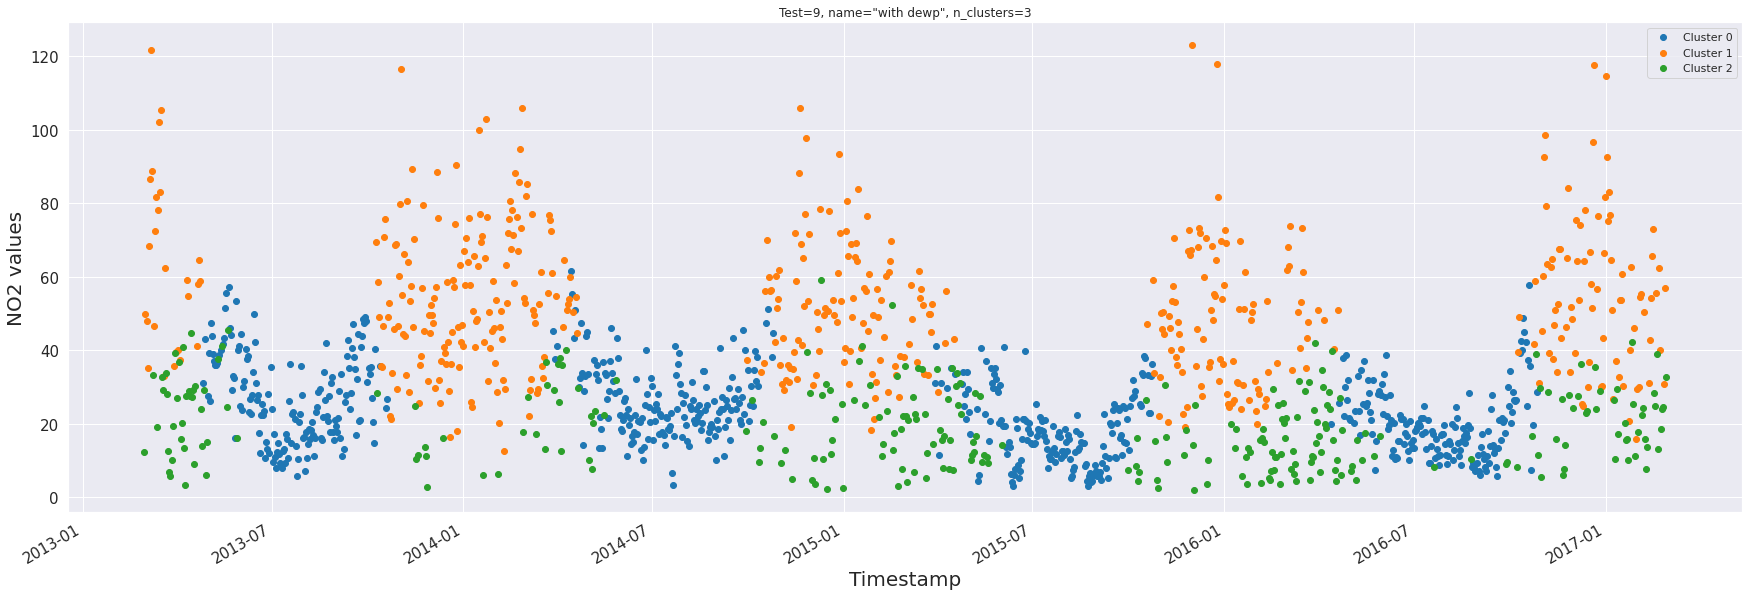

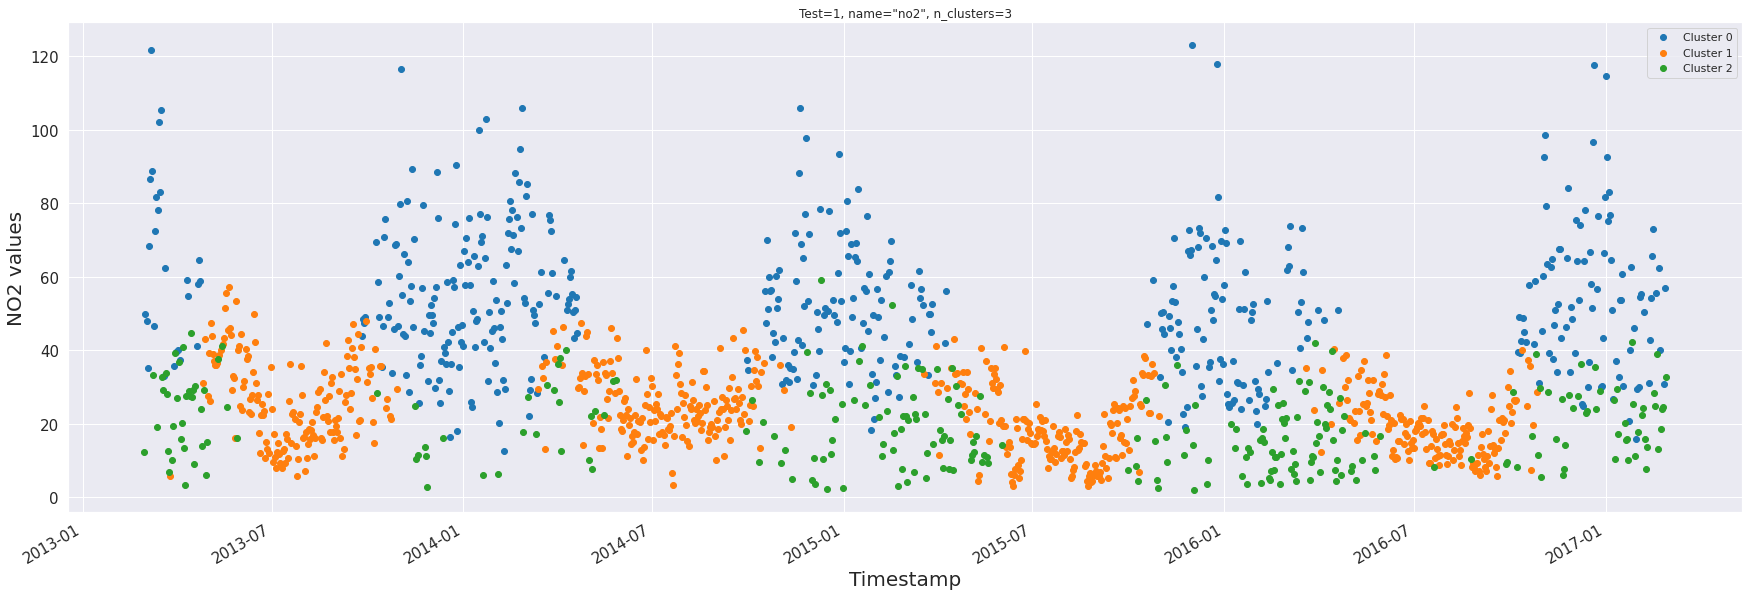

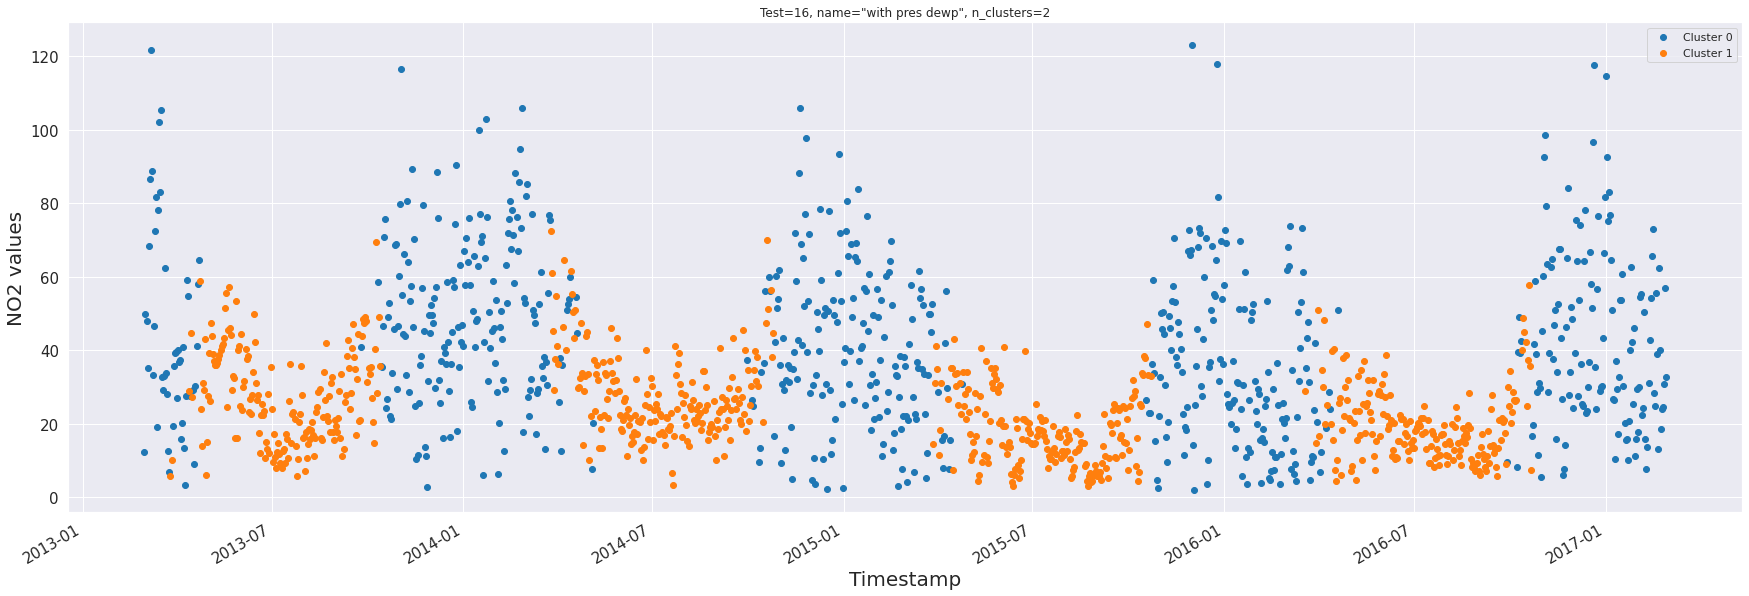

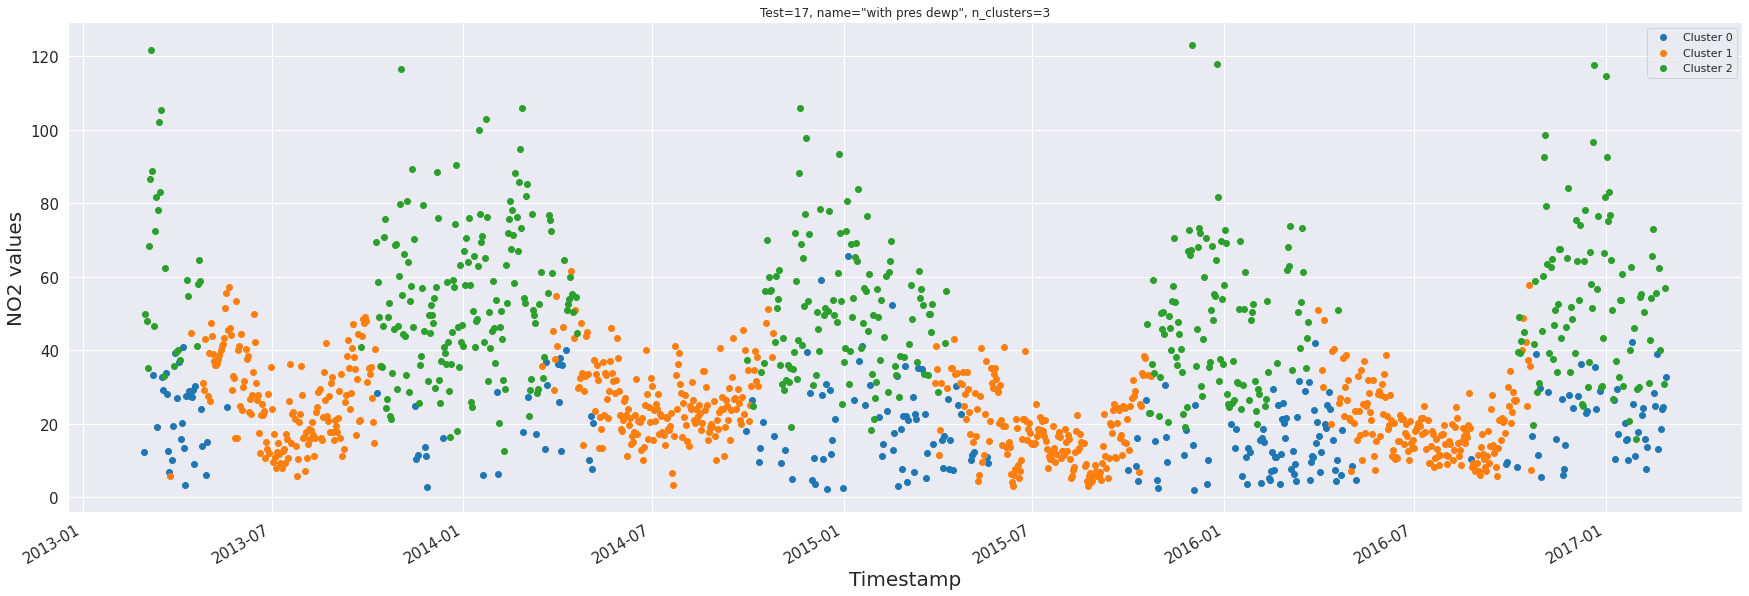

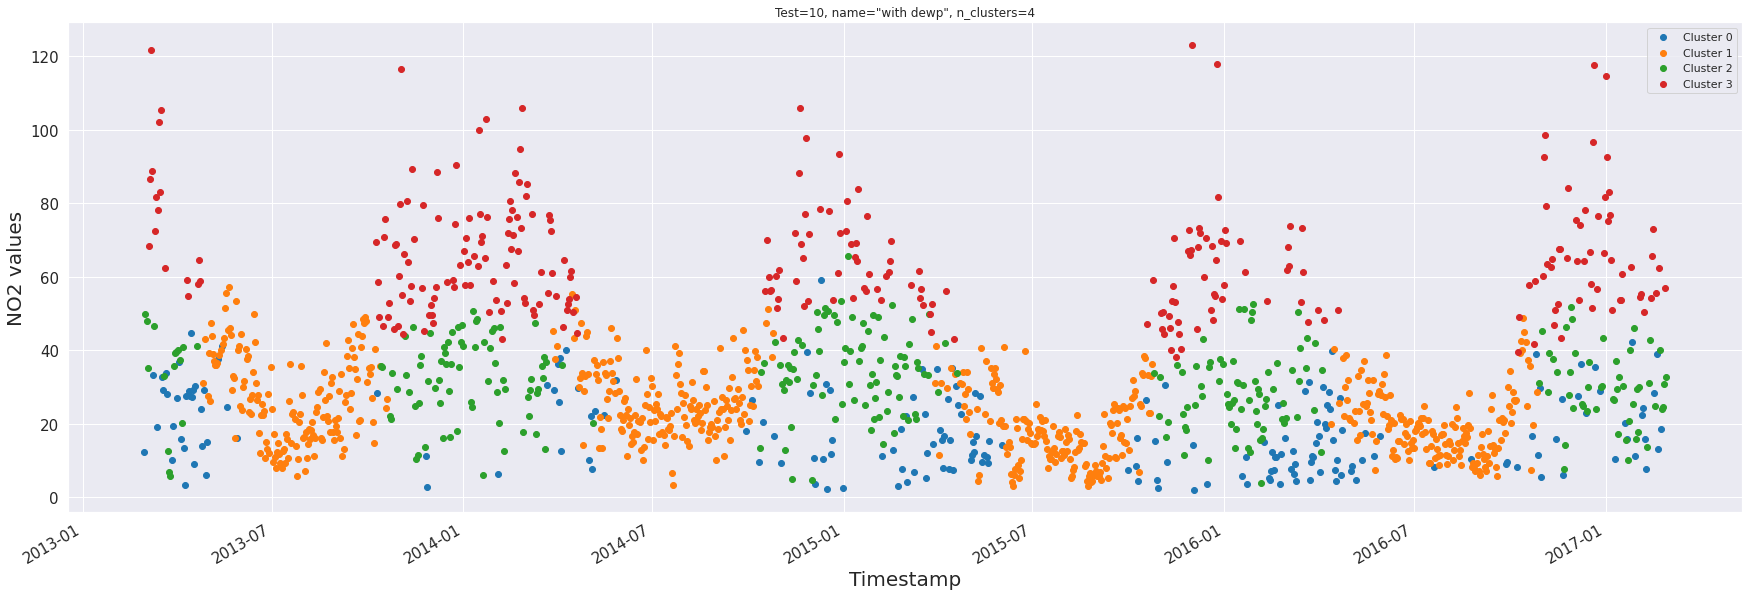

In [10]:
for i in sil_cal.index:
  plot_ts_clusters_scatter(data_list[i], 'Test={}, name="{}", n_clusters={}'.format(i, results.iloc[i, 0], results.iloc[i, 3]))

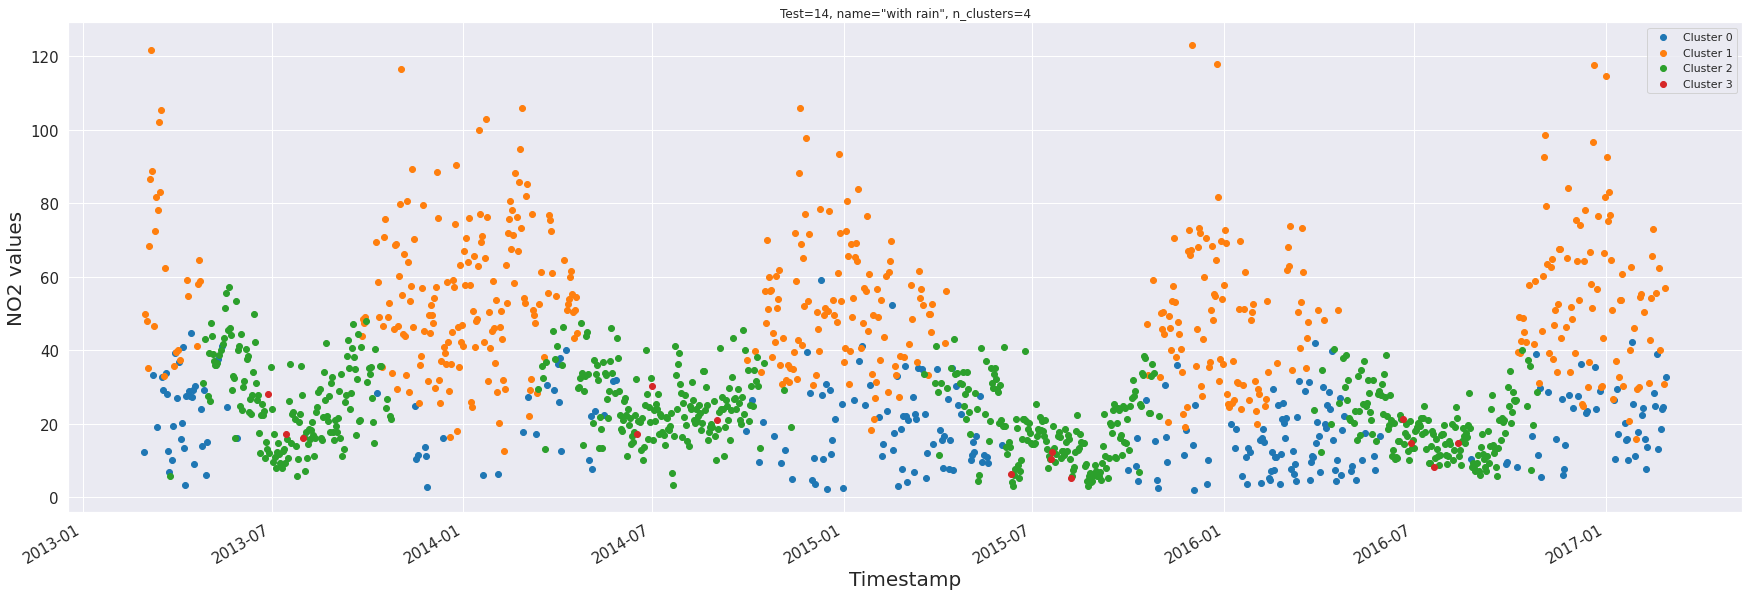

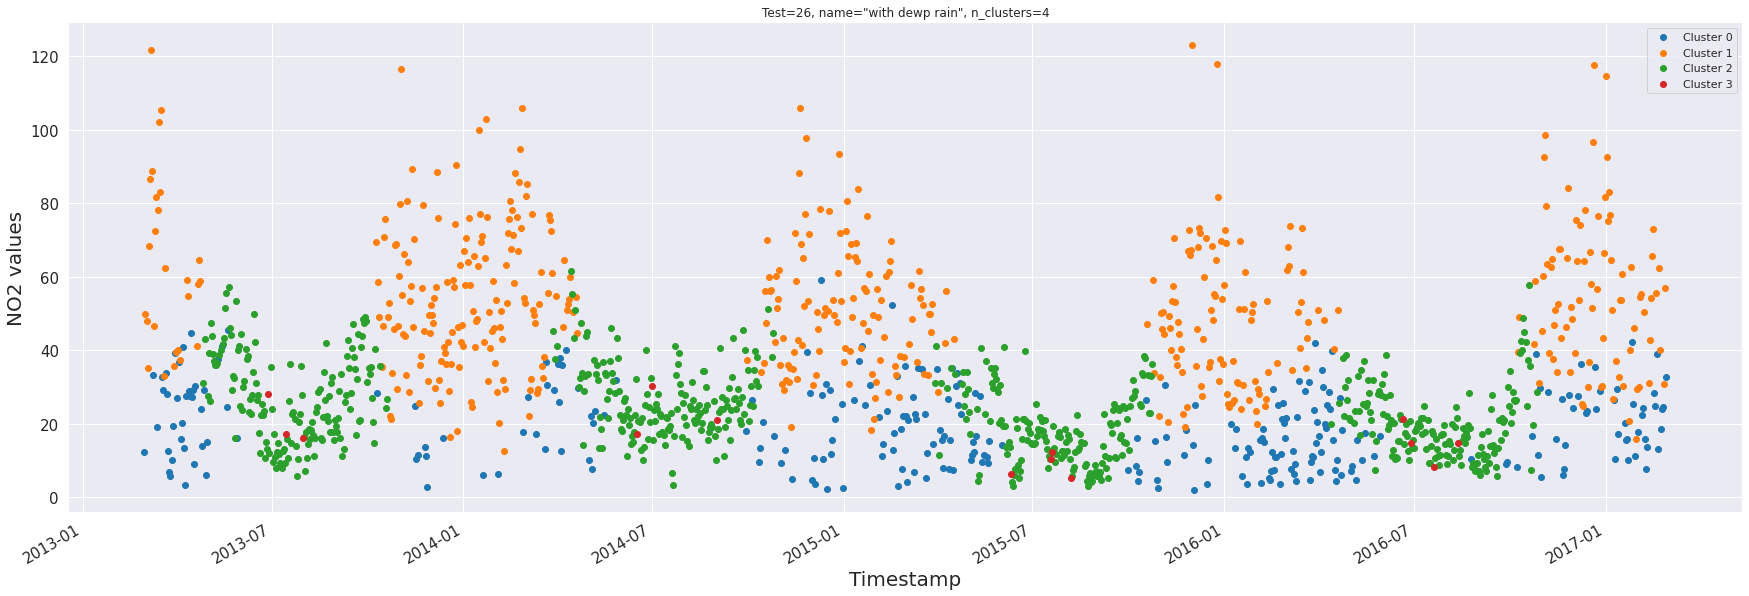

In [11]:
for i in dav.index:
  plot_ts_clusters_scatter(data_list[i], 'Test={}, name="{}", n_clusters={}'.format(i, results.iloc[i, 0], results.iloc[i, 3]))

In [12]:
# Get proportion of cluster with pattern "high" NO2 values (cluster 1) for test 9
best_df = data_list[9]
total = best_df.shape[0]
cluster1_size = best_df.loc[best_df['y'] == 1].shape[0]
print('Proportion of cluster 1 during the recorded time for test 9: {}'.format(cluster1_size/total))

Proportion of cluster 1 during the recorded time for test 9: 0.33607118412046544


FileNotFoundError: [Errno 2] No such file or directory: '/content/model_9_clusters_over_time.png'

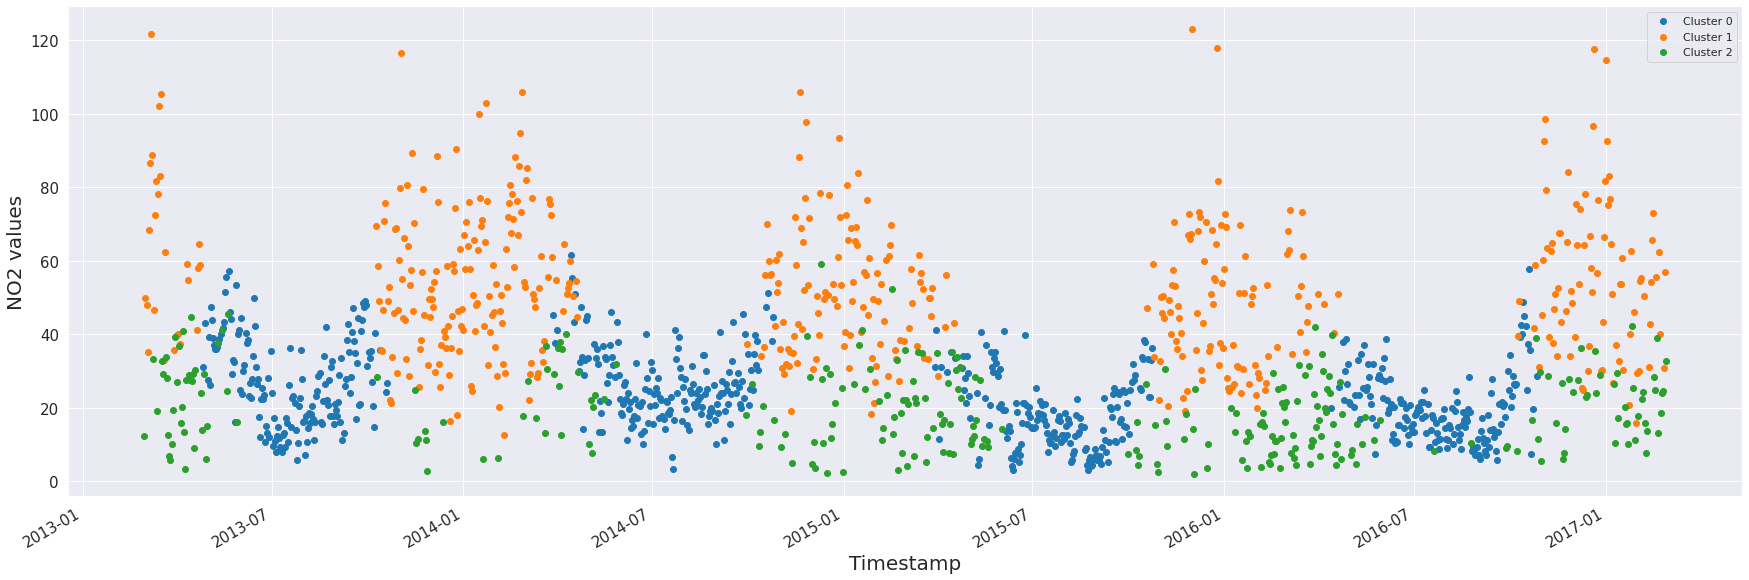

In [13]:
plot_ts_clusters_scatter(best_df, '')
plt.savefig('/content/model_9_clusters_over_time.png')

fig, ax = plot_3d_clusters(scale_data(data_list[1].drop(columns=['y'])), data_list[1]['y'].values)
ax.set_xlabel('NO2 values')
ax.set_ylabel('TEMP values')
ax.set_zlabel('WSPM values')
plt.title('Model 1 clusters')
plt.savefig('/content/model_1_3d_clusters.png')

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax1, ax2 = fig.subplots(1, 2)
ax1.boxplot(results['silhouette'], labels=['Silhouette Coefficient scores'])
ax2.boxplot(results['calinski'], labels=['Calinski-Harabasz index scores'])
plt.savefig('/content/boxplot_scores.png')